# **음악 스트리밍 서비스 kkbox의 고객 이탈률 예측**</br>


## **프로젝트의 필요성**</br>
> </br>
> 기업의 입장에서, 매출을 발생시키는 고객을 신규 유입시키는 데 발생하는 비용보다 기존 고객을 이탈하지 않도록 유지하는 비용이 더 낮음.
>
> 특히 음악 스트리밍과 같은 구독형 비즈니스 모델을 가진 서비스의 경우 기존 고객이 이탈하지 않도록 유지하는 것은 현재의 매출만이 아닌 미래의 현금 흐름 창출에도 중요한 요소로 작용.
> 
> 또한 고객의 이탈 데이터를 분석하여 현재 서비스 개선에 대한 의사결정의 근거를 마련할 수 있음.</br>
> </br>

## **목표**</br>
> </br>
> - 1차 : 머신 러닝을 통한 고객 전환 예측</br></br>
> - 2차 : 대쉬보드 생성</br></br>
> - 3차 : Slack을 통해 이탈 가능성이 높은 고객의 정보를 자동으로 전달할 수 있도록 시스템 구축</br>
></br>

## 추가적으로 생각해볼 수 있는 features

> </br>
> 사용자의 서비스 사용 횟수(일 단위) / 사용자의 총 서비스 가입 기간</br></br>
> </br></br>
> </br>
></br> 

In [214]:
import matplotlib.pyplot as plt
import pandas as pd
import jiho_module as jm
import numpy as np
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, min, max, datediff, sum, when, to_date, concat_ws, substring, lag, avg, count
from pyspark.sql.types import DateType
from pyspark.sql.window import Window

In [238]:
from importlib import reload
reload(jm)

<module 'jiho_module' from 'c:\\Users\\jiho\\Documents\\jiho_portfolio\\predict_churn_rate\\jiho_module.py'>

In [2]:
spark = SparkSession.builder.appName('predict_chrun_rate').getOrCreate()

In [3]:
train_df = spark.read.option('header', 'true').parquet('D:/kkbox-churn-prediction-challenge/data/churn_comp_refresh/id_encoding/data/new_train/new_train.parquet', inferSchema=True)
members_df = spark.read.option('header', 'true').parquet('D:/kkbox-churn-prediction-challenge/data/churn_comp_refresh/id_encoding/data/new_members/new_members.parquet', inferSchema=True)
transactions_df = spark.read.option('header', 'true').parquet('D:/kkbox-churn-prediction-challenge/data/churn_comp_refresh/id_encoding/data/new_transactions/new_transactions.parquet', inferSchema=True)
userlog_df = spark.read.option('header', 'true').parquet('D:/kkbox-churn-prediction-challenge/data/churn_comp_refresh/id_encoding/data/new_user_logs/new_user_logs-001.parquet', inferSchema=True)

### train_df 살펴보기

In [21]:
train_df_merged.printSchema()

root
 |-- msno: string (nullable = true)
 |-- is_churn: integer (nullable = true)



In [118]:
train_df_merged.count(), train_df_merged.select('msno').distinct().count()

(1963891, 1082190)

In [7]:
train_df_merged = train_df_merged.drop_duplicates(['msno'])

In [8]:
train_test = train_df_merged.unionAll(test)

In [9]:
test.select('msno').count()

907471

In [10]:
test.select('msno').distinct().count()

907471

In [11]:
train_test.select('msno').distinct().count()

1143472

In [124]:
train_df_merged.count()

1082190

In [20]:
test.filter(col('msno')==1).count()

0

In [6]:
print(train_df.filter(col('is_churn') == 0).count(), 
      train_df.filter(col('is_churn') == 1).count(), 
      round(train_df.filter(col('is_churn') == 1).count()/train_df.count()*100, 2), '%')
print(train_df_v2.filter(col('is_churn') == 0).count(), 
      train_df_v2.filter(col('is_churn') == 1).count(), 
      round(train_df_v2.filter(col('is_churn') == 1).count()/train_df_v2.count()*100, 2), '%')
print(train_df_merged.filter(col('is_churn') == 0).count(), 
      train_df_merged.filter(col('is_churn') == 1).count(), 
      round(train_df_merged.filter(col('is_churn') == 1).count()/train_df_v2.count()*100, 2), '%')

929460 63471 6.39 %
883630 87330 8.99 %
947710 134480 13.85 %


In [7]:
train_df_merged_grouped = train_df_merged.groupBy('is_churn').count()

In [9]:
train_df_merged_grouped.show()

+--------+------+
|is_churn| count|
+--------+------+
|       1|134480|
|       0|947710|
+--------+------+



In [22]:
np.array(train_df_merged_grouped.select('is_churn').collect()).reshape(-1)
np.array(train_df_merged_grouped.select('count').collect()).reshape(-1)

array([1, 0])

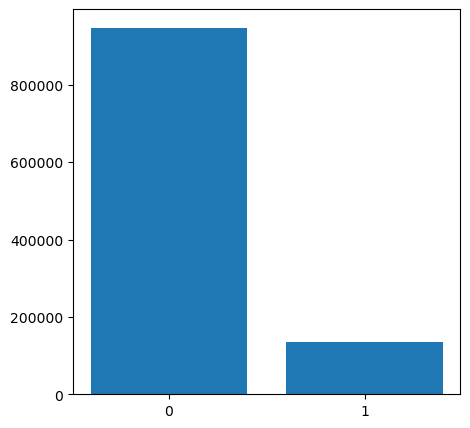

In [27]:
plt.figure(figsize=(5,5))
plt.bar(x=np.array(train_df_merged_grouped.select('is_churn').collect()).reshape(-1),
        height=np.array(train_df_merged_grouped.select('count').collect()).reshape(-1))
plt.xticks([0,1])
plt.show()

In [45]:
print(train_df.filter(col('msno').isNull()).count())
print(train_df.filter(col('is_churn').isNull()).count())
print(train_df_v2.filter(col('msno').isNull()).count())
print(train_df_v2.filter(col('is_churn').isNull()).count())

0
0
0
0


In [48]:
print(train_df.select('msno').distinct().count())
print(train_df_v2.select('msno').distinct().count())

992931
970960


### members_df 살펴보기

- members_df는 v2가 없고 v3만 있음
- v3는 2017년 11월 13일에 업데이트가 진행되었으며, 다른 데이터의 경우 2017년 3월 31일까지의 데이터만 담고 있음

In [49]:
members_df_v3.head()

Row(msno='Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=', city=1, bd=0, gender=None, registered_via=11, registration_init_time=20110911)

In [52]:
print('msno :', members_df_v3.filter(col('msno').isNull()).count())
print('city :', members_df_v3.filter(col('city').isNull()).count())
print('bd :',members_df_v3.filter(col('bd').isNull()).count())
print('gender :',members_df_v3.filter(col('gender').isNull()).count())
print('registered_via :',members_df_v3.filter(col('registered_via').isNull()).count())
print('registration_init_time :',members_df_v3.filter(col('registration_init_time').isNull()).count())

msno : 0
city : 0
bd : 0
gender : 4429505
registered_via : 0
registration_init_time : 0


In [54]:
print('bd == 0 :',members_df_v3.filter(col('bd')==0).count())

bd == 0 : 4540215


In [60]:
print('distinct city :', members_df_v3.select('city').distinct().orderBy(col('city')).collect())

distinct city : [Row(city=1), Row(city=3), Row(city=4), Row(city=5), Row(city=6), Row(city=7), Row(city=8), Row(city=9), Row(city=10), Row(city=11), Row(city=12), Row(city=13), Row(city=14), Row(city=15), Row(city=16), Row(city=17), Row(city=18), Row(city=19), Row(city=20), Row(city=21), Row(city=22)]


In [61]:
print('distinct registered_via :', members_df_v3.select('registered_via').distinct().orderBy(col('registered_via')).collect())

distinct registered_via : [Row(registered_via=-1), Row(registered_via=1), Row(registered_via=2), Row(registered_via=3), Row(registered_via=4), Row(registered_via=5), Row(registered_via=6), Row(registered_via=7), Row(registered_via=8), Row(registered_via=9), Row(registered_via=10), Row(registered_via=11), Row(registered_via=13), Row(registered_via=14), Row(registered_via=16), Row(registered_via=17), Row(registered_via=18), Row(registered_via=19)]


In [63]:
print('registered_via == -1 :', members_df_v3.filter(col('registered_via')==-1).count())

registered_via == -1 : 1


In [37]:
members_df_v3_groupby_city = members_df_v3.groupBy("city").count().select('*').orderBy('city')
members_df_v3_groupby_bd = members_df_v3.groupBy("bd").count().select('*').orderBy('bd')
members_df_v3_groupby_registered_via = members_df_v3.groupBy("registered_via").count().select('*').orderBy('registered_via')
members_df_v3_groupby_registration_init_time = members_df_v3.groupBy("registration_init_time").count().select('*').orderBy('registration_init_time')

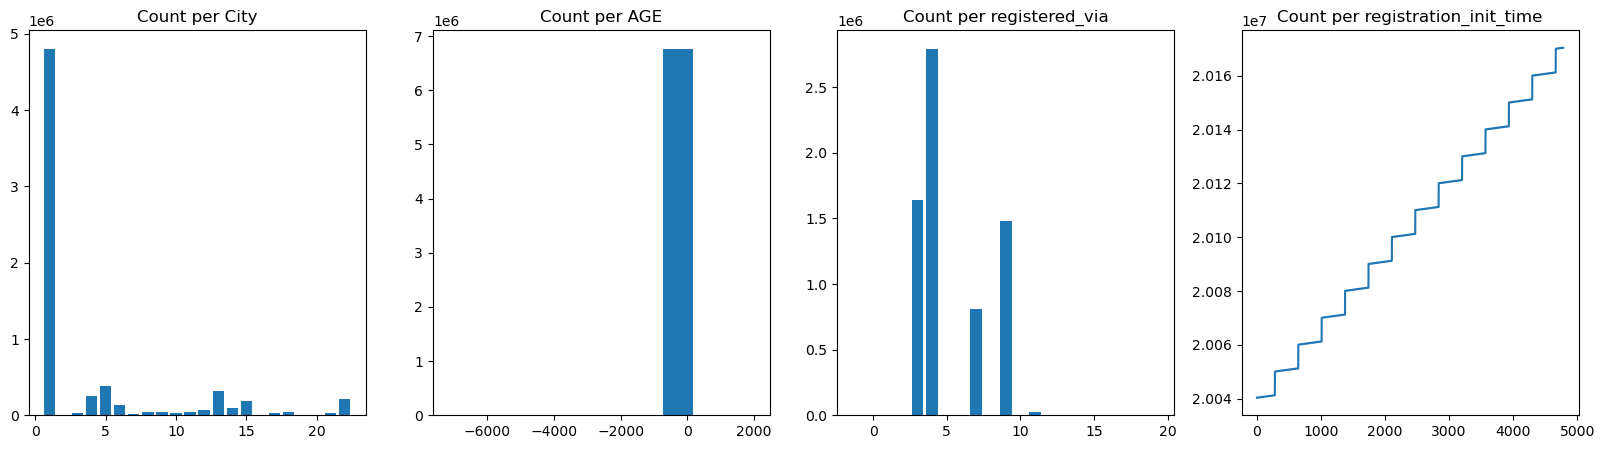

In [49]:
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.bar(x=np.array(members_df_v3_groupby_city.select('city').collect()).reshape(-1),
        height=np.array(members_df_v3_groupby_city.select('count').collect()).reshape(-1))
plt.title("Count per City")
plt.subplot(1,4,2)
plt.hist(x=np.array(members_df_v3.select('bd').collect()).reshape(-1))
plt.title("Count per AGE")
plt.subplot(1,4,3)
plt.bar(x=np.array(members_df_v3_groupby_registered_via.select('registered_via').collect()).reshape(-1),
        height=np.array(members_df_v3_groupby_registered_via.select('count').collect()).reshape(-1))
plt.title("Count per registered_via")
plt.subplot(1,4,4)
plt.plot(np.array(members_df_v3_groupby_registration_init_time.select('registration_init_time').collect()).reshape(-1))
plt.title("Count per registration_init_time")
plt.show()

In [73]:
print(members_df_v3.select(min('registration_init_time')).show())
print(members_df_v3.select(max('registration_init_time')).show())

+---------------------------+
|min(registration_init_time)|
+---------------------------+
|                   20040326|
+---------------------------+

None
+---------------------------+
|max(registration_init_time)|
+---------------------------+
|                   20170429|
+---------------------------+

None


### transaction_df 살펴보기

In [79]:
transactions_df_merged.printSchema()

root
 |-- msno: string (nullable = true)
 |-- payment_method_id: integer (nullable = true)
 |-- payment_plan_days: integer (nullable = true)
 |-- plan_list_price: integer (nullable = true)
 |-- actual_amount_paid: integer (nullable = true)
 |-- is_auto_renew: integer (nullable = true)
 |-- transaction_date: integer (nullable = true)
 |-- membership_expire_date: integer (nullable = true)
 |-- is_cancel: integer (nullable = true)



In [90]:
transactions_df_merged.select('msno').distinct().count()

2426143

In [111]:
transactions_df_merged.head()

Row(msno='YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=', payment_method_id=41, payment_plan_days=30, plan_list_price=129, actual_amount_paid=129, is_auto_renew=1, transaction_date=20150930, membership_expire_date=20151101, is_cancel=0)

In [107]:
transactions_df_merged.filter(col('msno')=='hqWmt5OeZ3ab3MZdXmYlEdMtmsBkKH9/wuqzFYh26W8=').orderBy(col('transaction_date')).show()

+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+
|                msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|
+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+
|hqWmt5OeZ3ab3MZdX...|               41|               30|            149|               149|            1|        20150101|              20171106|        0|
|hqWmt5OeZ3ab3MZdX...|               41|               30|            149|               149|            1|        20150104|              20171207|        0|
|hqWmt5OeZ3ab3MZdX...|               41|               30|            149|               119|            1|        20150123|              20180107|        0|
|hqWmt5OeZ3ab3MZdX...|               41|            

In [110]:
print(
    transactions_df.select(min('transaction_date')).show(),
    transactions_df.select(max('transaction_date')).show(),
    transactions_df_v2.select(min('transaction_date')).show(),
    transactions_df_v2.select(max('transaction_date')).show()
)

+---------------------+
|min(transaction_date)|
+---------------------+
|             20150101|
+---------------------+

+---------------------+
|max(transaction_date)|
+---------------------+
|             20170228|
+---------------------+

+---------------------+
|min(transaction_date)|
+---------------------+
|             20150101|
+---------------------+

+---------------------+
|max(transaction_date)|
+---------------------+
|             20170331|
+---------------------+

None None None None


In [115]:
print(
    transactions_df.filter(col('msno')=='hqWmt5OeZ3ab3MZdXmYlEdMtmsBkKH9/wuqzFYh26W8=').orderBy(col('transaction_date')).show(),
    transactions_df_v2.filter(col('msno')=='hqWmt5OeZ3ab3MZdXmYlEdMtmsBkKH9/wuqzFYh26W8=').orderBy(col('transaction_date')).show()
    )

+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+
|                msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|
+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+
|hqWmt5OeZ3ab3MZdX...|               41|               30|            149|               149|            1|        20151223|              20160123|        0|
|hqWmt5OeZ3ab3MZdX...|               41|               30|            149|               149|            1|        20151224|              20130602|        1|
|hqWmt5OeZ3ab3MZdX...|               41|               30|            149|               149|            1|        20151224|              20131226|        1|
|hqWmt5OeZ3ab3MZdX...|               41|            

In [119]:
print(
    'payment_method_id : ', transactions_df_merged.select('payment_method_id').distinct().orderBy('payment_method_id').collect(), '\n',
    'payment_plan_days : ', transactions_df_merged.select('payment_plan_days').distinct().orderBy('payment_plan_days').collect(), '\n',
    'plan_list_price : ', transactions_df_merged.select('plan_list_price').distinct().orderBy('plan_list_price').collect(), '\n',
    'actual_amount_paid : ', transactions_df_merged.select('actual_amount_paid').distinct().orderBy('actual_amount_paid').collect(), '\n',
    'is_auto_renew : ', transactions_df_merged.select('is_auto_renew').distinct().orderBy('is_auto_renew').collect()
)

payment_method_id :  [Row(payment_method_id=1), Row(payment_method_id=2), Row(payment_method_id=3), Row(payment_method_id=4), Row(payment_method_id=5), Row(payment_method_id=6), Row(payment_method_id=7), Row(payment_method_id=8), Row(payment_method_id=10), Row(payment_method_id=11), Row(payment_method_id=12), Row(payment_method_id=13), Row(payment_method_id=14), Row(payment_method_id=15), Row(payment_method_id=16), Row(payment_method_id=17), Row(payment_method_id=18), Row(payment_method_id=19), Row(payment_method_id=20), Row(payment_method_id=21), Row(payment_method_id=22), Row(payment_method_id=23), Row(payment_method_id=24), Row(payment_method_id=25), Row(payment_method_id=26), Row(payment_method_id=27), Row(payment_method_id=28), Row(payment_method_id=29), Row(payment_method_id=30), Row(payment_method_id=31), Row(payment_method_id=32), Row(payment_method_id=33), Row(payment_method_id=34), Row(payment_method_id=35), Row(payment_method_id=36), Row(payment_method_id=37), Row(payment_me

### user_log 데이터 살펴보기

In [120]:
user_logs_df.head()

Row(msno='rxIP2f2aN0rYNp+toI0Obt/N/FYQX8hcO1fTmmy2h34=', date=20150513, num_25=0, num_50=0, num_75=0, num_985=0, num_100=1, num_unq=1, total_secs=280.335)

In [22]:
user_logs_df_merged = user_logs_df.union(user_logs_df_v2)

In [127]:
user_logs_df_merged.select(min('date')).show()

+---------+
|min(date)|
+---------+
| 20150101|
+---------+



In [129]:
print(
    'msno : ', user_logs_df_merged.filter(col('msno').isNull()).count(), '\n',
    'date : ', user_logs_df_merged.filter(col('date').isNull()).count(),'\n',
    'num_25 : ', user_logs_df_merged.filter(col('num_25').isNull()).count(),'\n',
    'num_50 : ', user_logs_df_merged.filter(col('num_50').isNull()).count(),'\n',
    'num_75 : ', user_logs_df_merged.filter(col('num_75').isNull()).count(),'\n',
    'num_985 : ', user_logs_df_merged.filter(col('num_985').isNull()).count(),'\n',
    'num_100 : ', user_logs_df_merged.filter(col('num_100').isNull()).count(),'\n',
    'num_unq : ', user_logs_df_merged.filter(col('num_unq').isNull()).count(),'\n',
    'total_secs : ', user_logs_df_merged.filter(col('total_secs').isNull()).count()
)


msno :  0 
 date :  0 
 num_25 :  0 
 num_50 :  0 
 num_75 :  0 
 num_985 :  0 
 num_100 :  0 
 num_unq :  0 
 total_secs :  0


In [71]:
transactions_df_merged.columns

Index(['msno', 'payment_method_id', 'payment_plan_days', 'plan_list_price',
       'actual_amount_paid', 'is_auto_renew', 'transaction_date',
       'membership_expire_date', 'is_cancel'],
      dtype='object')

In [73]:
active_count =  user_logs_df_merged.groupBy("msno")[['num_25']].agg('count').rename(columns={'num_25' : 'active_days'}).reset_index()
paid_user = transactions_df_merged.groupBy("msno")[['is_cancel']].agg('count').rename(columns={'is_cancel' : 'transaction_count'}).reset_index()

In [36]:
len(transactions_df_merged.select('msno').distinct())

2426143

In [74]:
len(active_count), len(paid_user)

(5339422, 2426143)

In [59]:
len(members_df_v3)

6769473

In [ ]:
len(members_df_v3)

In [62]:
active_count.head(10)

,msno,active_days
0,rxIP2f2aN0rYNp+toI0Obt/N/FYQX8hcO1fTmmy2h34=,142
1,yxiEWwE9VR5utpUecLxVdQ5B7NysUPfrNtGINaM2zA8=,680
2,PNxIsSLWOJDCm7pNPFzRO/6Mmg2WeZA2nf6hw6t1x3g=,119
3,KXF9c/T66LZIzFq+xS64icWMhDQE6miCZAtdXRjZHX8=,198
4,oy2721XIrBu+MEh8XjPTlt5b7gCronoHf/oFN+YwIv8=,502
5,zD6AnHn/qhjoROJjnwmKUsKJ1Xj4nZ3fJzVShr+LISo=,742
6,OcZ3fKQzHrL1BuzuFRzUiwPr8l9P8JKCFpafdYf5sCY=,646
7,FnqNUBvN8mysLeKba1tBkGZDLM1DhvC5iloOKM1wiuQ=,575
8,dW5DQO92XaG024D2QYmktyUnLc2axil74zUPAhF8sEs=,612
9,6QoLmaBbt/q8hVY7VBT72CurH3dTd6TT/7rK3qfwxqg=,213


In [16]:
transactions_df_v2.filter(col('msno') == 'ORUaiH4z66kfVaKGvnC4qukcfhCLY9X9Y2LWcLncvYo=').show()

+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+
|                msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|
+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+
|ORUaiH4z66kfVaKGv...|               41|               30|             99|                99|            1|        20170322|              20170422|        0|
+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+



## 데이터 병합

In [56]:
transaction_grouped = transactions_df_merged.groupBy('msno').count()
logs_grouped = user_logs_df_merged.groupBy('msno').count()

In [57]:
train_memeber = train_df_merged.join(members_df_v3, on='msno', how='left')
train_transaction = train_df_merged.join(transaction_grouped, on='msno', how='left')
train_log = train_df_merged.join(logs_grouped, on='msno', how='left')

In [58]:
print(train_memeber.filter(col('city').isNotNull()).count(), train_memeber.filter(col('city').isNull()).count())
print(train_transaction.filter(col('count').isNotNull()).count(), train_transaction.filter(col('count').isNull()).count())
print(train_log.filter(col('count').isNotNull()).count(), train_log.filter(col('count').isNull()).count())

961431 120759
1082190 0
955159 127031


In [ ]:
df_target = train_df_merged.join(members_df_v3, on='msno', how='inner').join(transaction_grouped, on='msno', how='inner').join(logs_grouped, on='msno', how='inner')

In [62]:
df_target = train_df_merged.join(members_df_v3, on='msno', how='left').join(transaction_grouped, on='msno', how='left').join(logs_grouped, on='msno', how='left')

In [64]:
df_target.count()

1082190

In [6]:
transactions_df_merged = transactions_df_merged.withColumn('prev_expire_date', lag('membership_expire_date').over(Window.partitionBy('msno').orderBy('transaction_date','membership_expire_date')))

In [7]:
transactions_df_merged = transactions_df_merged.withColumn('periods', when(transactions_df_merged.is_cancel == 0, datediff(transactions_df_merged['membership_expire_date'], transactions_df_merged['transaction_date']))
                                             .otherwise(datediff(transactions_df_merged['membership_expire_date'], transactions_df_merged['prev_expire_date']))
                                )

In [8]:
transaction_total_periods_per_user = transactions_df_merged.groupBy("msno").agg(sum('periods').alias('total_periods'))

In [15]:
logs_grouped = user_logs_df_merged.groupBy('msno').count()
logs_grouped = logs_grouped.join(transaction_total_periods_per_user, on='msno', how='left')
logs_grouped = logs_grouped.withColumn('active_per_periods', col('count') / col('total_periods'))

In [17]:
df_target = train_df_merged.join(members_df_v3, on='msno', how='inner').join(logs_grouped, on='msno', how='inner')

In [24]:
transaction_total_periods_per_user.columns

['msno', 'total_periods']

In [19]:
df_target = df_target.drop('msno')

In [20]:
df_target.columns

['is_churn',
 'city',
 'bd',
 'gender',
 'registered_via',
 'registration_init_time',
 'count',
 'total_periods',
 'active_per_periods']

In [21]:
df_target.toPandas().to_csv('D:/kkbox-churn-prediction-challenge/data/churn_comp_refresh/df_target2.csv')

In [23]:
df_target.count()

955126

In [26]:
df20230408 = pd.read_csv('D:/kkbox-churn-prediction-challenge/data/churn_comp_refresh/df_target3.csv')

<AxesSubplot: xlabel='active_per_periods', ylabel='Density'>

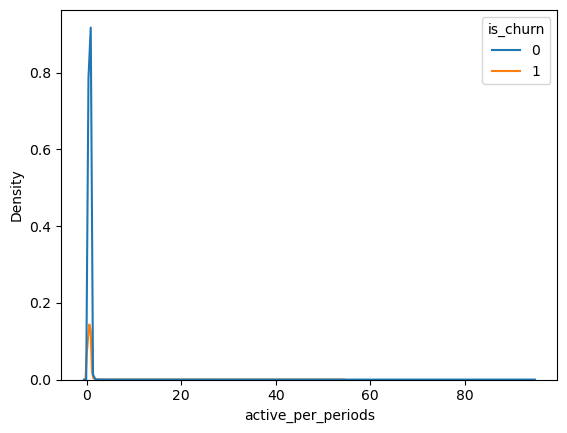

In [38]:
sns.kdeplot(data=df20230408, x='active_per_periods', hue='is_churn')

In [27]:
transactions_df.printSchema()

root
 |-- msno_num: integer (nullable = true)
 |-- payment_method_id: integer (nullable = true)
 |-- payment_plan_days: integer (nullable = true)
 |-- plan_list_price: integer (nullable = true)
 |-- actual_amount_paid: integer (nullable = true)
 |-- is_auto_renew: integer (nullable = true)
 |-- transaction_date: integer (nullable = true)
 |-- membership_expire_date: integer (nullable = true)
 |-- is_cancel: integer (nullable = true)



In [4]:
transactions_df_grouped = transactions_df.groupBy('msno_num').count()
userlog_df_grouped = userlog_df.groupBy('msno_num').count()

In [5]:
userlog_df_grouped.count()

5339422

In [5]:
train_member = train_df.join(members_df, on='msno_num', how='inner')

In [6]:
train_member_transaction = train_member.join(transactions_df_grouped, on='msno_num', how='inner')
train_memeber_log = train_member.join(userlog_df_grouped, on='msno_num', how='inner')

In [7]:
train_member_transaction_log = train_member_transaction.join(train_memeber_log, on='msno_num', how='inner')

In [8]:
target_id = train_member_transaction_log.select('msno_num')

In [9]:
sample = target_id.sample(0.005)

In [10]:
pd_sample = sample.toPandas()

In [11]:
train_sample = train_df.filter(col('msno_num').isin(list(pd_sample['msno_num'])))
members_sample = members_df.filter(col('msno_num').isin(list(pd_sample['msno_num'])))
transaction_sample = transactions_df.filter(col('msno_num').isin(list(pd_sample['msno_num'])))
userlog_sample = userlog_df.filter(col('msno_num').isin(list(pd_sample['msno_num'])))

In [14]:
train_sample.write.parquet('D:/kkbox-churn-prediction-challenge/data/sample/train_random_sample.parquet')
members_sample.write.parquet('D:/kkbox-churn-prediction-challenge/data/sample/members_random_sample.parquet')
transaction_sample.write.parquet('D:/kkbox-churn-prediction-challenge/data/sample/transaction_random_sample.parquet')

In [34]:
total_periods = transactions_df_merged.groupBy('msno').agg(sum('periods').alias('total_periods'))

In [7]:
user_log_avg = (user_logs_df_merged
                .groupBy('msno')
                .agg(count('*').alias('count'), avg('num_25') ,avg('num_50'), avg('num_75'),avg('num_985'),avg('num_100'),avg('num_unq'),avg('total_secs'))
                )

In [265]:
train_df = pd.read_parquet('./sample_data/sample_train.parquet')
members_df = pd.read_parquet('./sample_data/sample_members.parquet')
transaction_df = pd.read_parquet('./sample_data/sample_transactions.parquet')
userlog_df = pd.read_parquet('./sample_data/sample_user_logs.parquet')

## Transaction_data EDA

In [266]:
transaction_df['transaction_date'] = pd.to_datetime(transaction_df['transaction_date'], format='%Y%m%d')
transaction_df['membership_expire_date'] = pd.to_datetime(transaction_df['membership_expire_date'], format='%Y%m%d')

In [267]:
transaction_filter1 = (transaction_df['transaction_date'] < transaction_df['membership_expire_date'])
transaction_filter2 = ((transaction_df['membership_expire_date'] - transaction_df['transaction_date']).dt.days < transaction_df['payment_plan_days'] * 3)

In [268]:
transaction_df_filtered = transaction_df[transaction_filter1 & transaction_filter2]

In [269]:
transaction_df_filtered.loc[:,'lag_membership_expire_date'] = transaction_df_filtered.sort_values(by='membership_expire_date', ascending=True).groupby('msno_num')['membership_expire_date'].shift(1)

C:\Users\jiho\AppData\Local\Temp\ipykernel_13340\1994290194.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transaction_df_filtered.loc[:,'lag_membership_expire_date'] = transaction_df_filtered.sort_values(by='membership_expire_date', ascending=True).groupby('msno_num')['membership_expire_date'].shift(1)


In [270]:
transaction_df_filtered.loc[:,'period'] = np.where(
    transaction_df_filtered['is_cancel'] == 0 ,
    (transaction_df_filtered['membership_expire_date'] - transaction_df_filtered['transaction_date']).dt.days,
    (transaction_df_filtered['lag_membership_expire_date'] - transaction_df_filtered['membership_expire_date']).dt.days
)

C:\Users\jiho\AppData\Local\Temp\ipykernel_13340\1936647700.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transaction_df_filtered.loc[:,'period'] = np.where(


<AxesSubplot: ylabel='Count'>

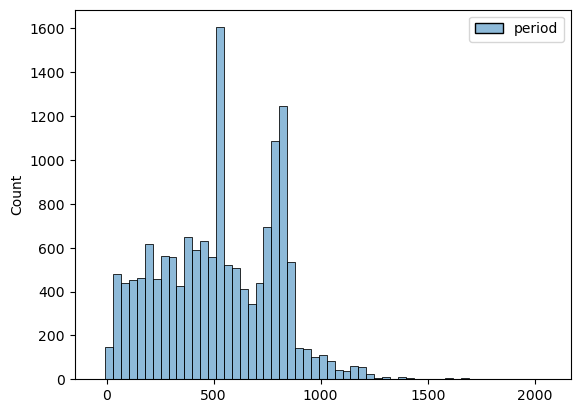

In [271]:
sns.histplot(transaction_df_filtered.groupby('msno_num')[['period']].sum())

In [272]:
train_period = train_df.join(transaction_df_filtered.groupby('msno_num')[['period']].sum(), on='msno_num', how='inner')

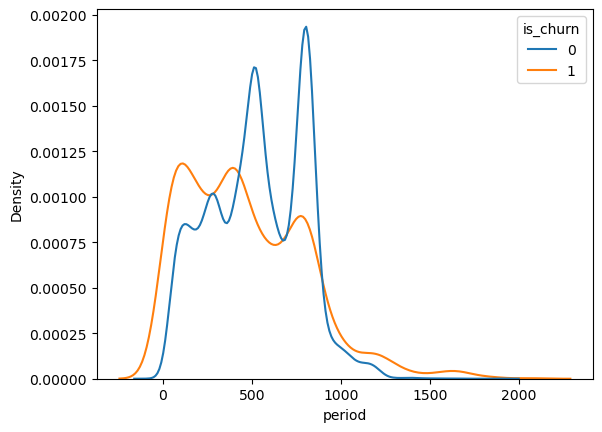

In [273]:
jm.compare_density(train_period, 'period')

## User Log EDA

In [274]:
userlog_df[userlog_df.total_secs > 86400]
userlog_filter1 = (userlog_df.total_secs > 0)
userlog_df_filtered = userlog_df[userlog_filter1]

In [275]:
userlog_df_filtered

,msno_num,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,311995,20150127,6,3,2,2,25,22,7311.623
1,311995,20150520,4,1,2,0,13,12,3252.325
2,311995,20150728,0,1,0,0,12,11,3135.897
3,311995,20151125,2,0,2,3,27,20,6353.843
4,311995,20160418,0,0,0,0,21,14,2991.098
...,...,...,...,...,...,...,...,...,...
4454855,7301526,20161226,4,1,4,1,50,10,12926.347
4454856,7301526,20161228,0,1,3,0,6,2,1969.598
4454857,7301526,20170103,0,0,1,1,0,2,337.562
4454858,7301526,20170104,1,1,1,1,8,5,2353.406


(0.0, 500000.0)

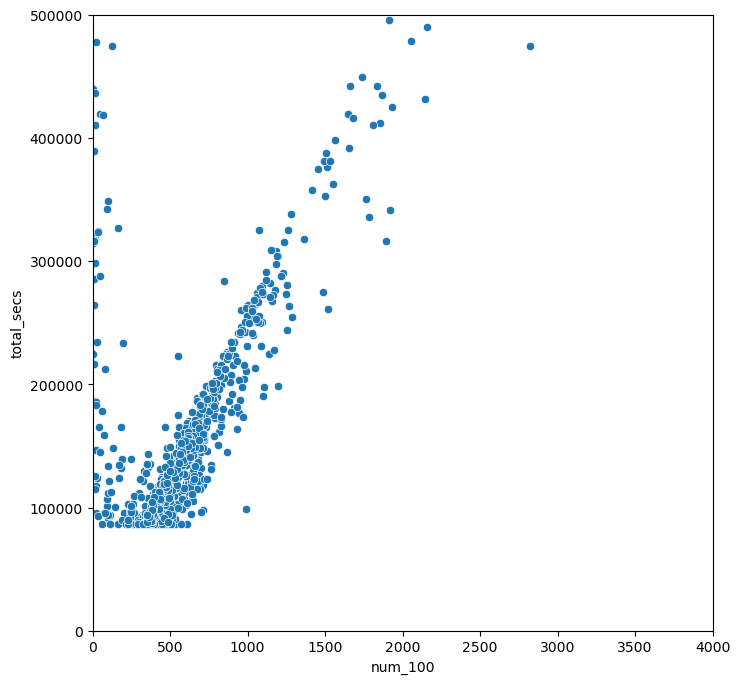

In [278]:
plt.figure(figsize=(8,8))
sns.scatterplot(x=(userlog_df_filtered[userlog_df_filtered.total_secs > 86400].num_100), y=userlog_df_filtered[userlog_df_filtered.total_secs > 86400].total_secs)
plt.xlim([0, 4000])
plt.ylim([0,500000])

In [279]:
userlog_df_grouped_avg = (userlog_df_filtered
                          .groupby('msno_num')
                          .agg({
                            'msno_num' : 'count',
                            'num_25' : 'mean',
                            'num_50' : 'mean',
                            'num_75' : 'mean',
                            'num_985' : 'mean',
                            'num_100' : 'mean',
                            'num_unq' : 'mean',
                            'total_secs' : 'mean'
                          })
                          )

In [282]:
train_df

,msno_num,is_churn
0,12120,0
1,13193,0
2,17474,1
3,19991,0
4,20371,0
...,...,...
15294,7362310,0
15295,7363415,0
15296,7373309,1
15297,7373344,0


In [280]:
userlog_df_grouped_avg

,msno_num,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
msno_num,,,,,,,,
1400,175,0.520000,0.262857,0.308571,0.377143,76.097143,58.777143,17091.255457
1429,277,8.400722,1.927798,1.368231,1.620939,19.072202,24.599278,5738.887285
2994,582,18.369416,2.347079,1.321306,1.237113,39.144330,56.785223,10310.834806
3018,270,9.303704,1.777778,0.944444,0.562963,16.218519,23.881481,4430.969270
3397,535,3.609346,0.930841,0.642991,0.616822,16.551402,18.186916,4280.917465
...,...,...,...,...,...,...,...,...
7374403,85,2.141176,0.741176,0.400000,0.423529,66.741176,39.964706,17078.558294
7375076,21,4.380952,1.285714,0.476190,0.476190,4.666667,10.095238,1649.737476
7375630,47,4.553191,2.340426,1.297872,0.936170,1.957447,9.382979,1229.187000


In [281]:
train_log = train_df.join(userlog_df_grouped_avg, on='msno_num', how='inner', )

ValueError: columns overlap but no suffix specified: Index(['msno_num'], dtype='object')

In [262]:
train_log

,msno_num,is_churn,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,12120,0,8.309783,1.961957,1.177536,0.851449,18.677536,22.920290,5070.038375
1,13193,0,1.086614,0.328084,0.309711,0.451444,12.341207,13.598425,3528.667079
2,17474,1,2.964286,2.071429,1.392857,4.428571,24.428571,27.321429,7721.734107
3,19991,0,4.103448,0.793103,0.241379,0.793103,26.241379,27.241379,6884.835000
4,20371,0,5.052632,1.421053,1.093567,0.771930,21.122807,25.081871,4685.818275
...,...,...,...,...,...,...,...,...,...
15294,7362310,0,8.589641,2.398406,1.722444,1.555113,26.579017,36.266932,7794.794839
15295,7363415,0,6.939114,1.297048,1.114391,1.012915,18.822878,26.964945,5112.401839
15296,7373309,1,5.890578,1.641337,1.471125,1.285714,106.234043,88.194529,25573.025778
15297,7373344,0,2.000000,0.400000,0.200000,1.000000,2.400000,4.000000,827.759800


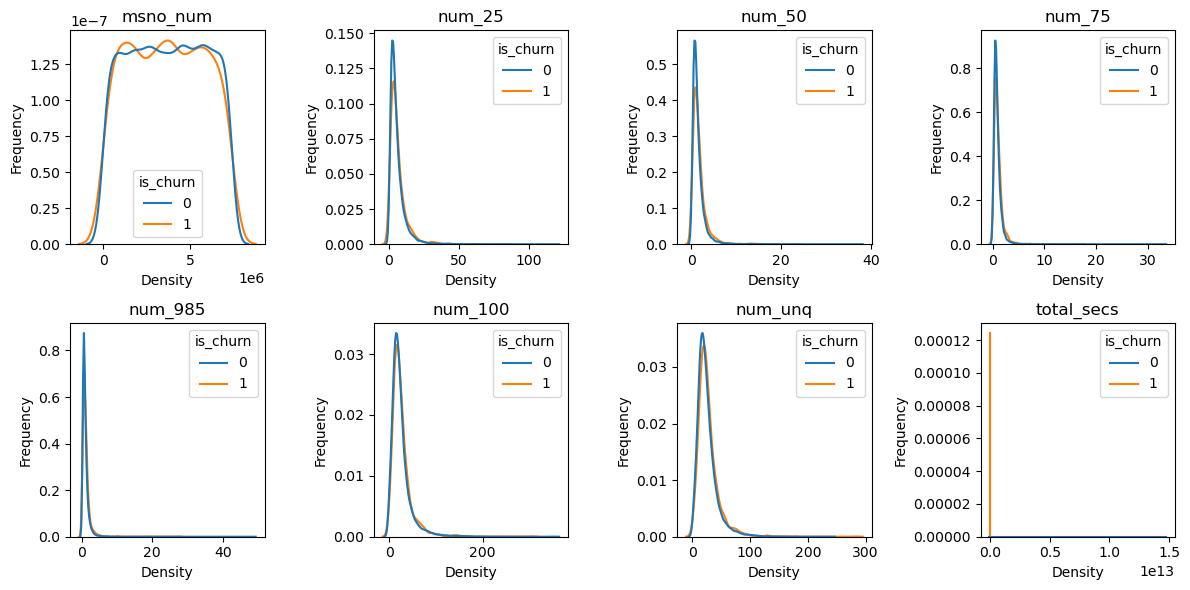

In [228]:
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for idx, col in enumerate(['msno_num', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs']):
    ax = axs.flatten()[idx]
    jm.compare_density(train_log, col, ax=ax)
    ax.set_title(col)
    ax.set_xlabel('Density')
    ax.set_ylabel('Frequency')
    
plt.tight_layout()
plt.show()

In [287]:
train_log[train_log['is_churn'] == 0]['total_secs'].mean(), train_log[train_log['is_churn'] == 1]['total_secs'].mean()

(1099654482.137567, 6952.987861029869)

In [289]:
(train_log[train_log['is_churn'] == 0]['total_secs']).max()

14686898154304.082

In [291]:
train_log[train_log['total_secs'] == train_log['total_secs'].max()]

,msno_num,is_churn,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
6013,5599444,0,1.737261,0.417197,0.340764,0.43949,25.914013,22.292994,1.468690e+13


In [293]:
userlog_df[userlog_df['msno_num'] == 5599444].sort_values('total_secs')

,msno_num,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
1656960,5599444,20150816,1,0,0,0,2,3,-9.223372e+15
1656899,5599444,20151004,1,0,0,0,9,10,-9.223372e+15
1656973,5599444,20150817,13,0,0,0,296,13,-9.223372e+15
1657090,5599444,20150828,1,1,1,2,20,9,-9.223372e+15
1656755,5599444,20150920,0,0,1,0,26,27,-9.223372e+15
...,...,...,...,...,...,...,...,...,...
1657122,5599444,20160828,0,1,0,0,116,108,2.681623e+04
1656715,5599444,20170115,0,0,0,1,113,86,2.805360e+04
1657290,5599444,20170320,8,2,4,1,111,109,2.820872e+04
1657081,5599444,20160404,3,0,0,0,124,52,3.280939e+04


In [169]:
userlog_df['date'] =pd.to_datetime(userlog_df['date'], format='%Y%m%d')

<AxesSubplot: xlabel='date', ylabel='Count'>

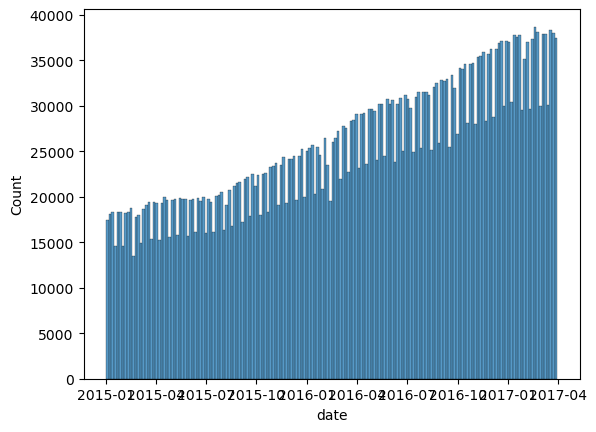

In [170]:
# 유저 로그가 선형적으로 증가하는 모습을 보임
# 주기성은 어느정도 있는 것으로 보임

sns.histplot(userlog_df['date'])

In [317]:
score = dict(zip(pd.to_datetime(pd.date_range('2015-01-01', '2017-03-31'), '%Y%m%d'), np.linspace(0,1,821)))

In [318]:
userlog_df['active_score'] = userlog_df['date'].map(score)

In [319]:
userlog_df

,msno_num,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,active_score
0,311995,20150127,6,3,2,2,25,22,7311.623,NaN
1,311995,20150520,4,1,2,0,13,12,3252.325,NaN
2,311995,20150728,0,1,0,0,12,11,3135.897,NaN
3,311995,20151125,2,0,2,3,27,20,6353.843,NaN
4,311995,20160418,0,0,0,0,21,14,2991.098,NaN
...,...,...,...,...,...,...,...,...,...,...
4454855,7301526,20161226,4,1,4,1,50,10,12926.347,NaN
4454856,7301526,20161228,0,1,3,0,6,2,1969.598,NaN
4454857,7301526,20170103,0,0,1,1,0,2,337.562,NaN
4454858,7301526,20170104,1,1,1,1,8,5,2353.406,NaN


In [312]:
user_active_score = userlog_df.groupby('msno_num')[['active_score']].mean()

In [297]:
train_user_active = train_df.join(user_active_score, on='msno_num', how='inner')

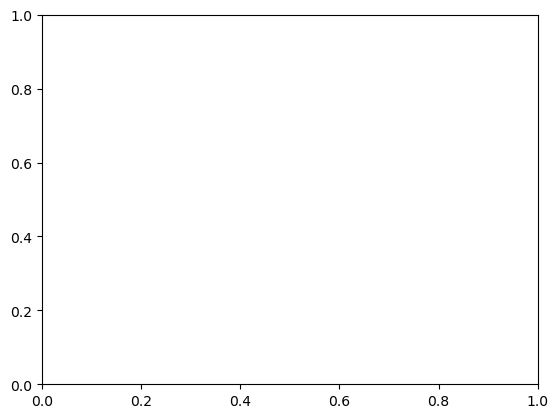

In [298]:
jm.compare_density(train_user_active, 'active_score')